# Fine-Tuning

In [1]:
import kagglehub

path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")
print("Path to dataset files:", path)


100%|██████████| 149M/149M [00:04<00:00, 37.0MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1


In [2]:
import os

dataset_path = "/root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1"
print("Contents of dataset folder:", os.listdir(dataset_path))


Contents of dataset folder: ['Training', 'Testing']


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.transforms as transforms
import torchvision.models as models
import os
from PIL import Image

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

torch.backends.cudnn.benchmark = True  # Optimized for faster training

# Dataset paths
train_dataset_path = "/root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1/Training"
test_dataset_path = "/root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1/Testing"


Using device: cuda


In [4]:
# Image transformations (Resizing for Inception v3)
transform = transforms.Compose([
    transforms.Resize((299, 299)),  # Required size for Inception v3
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Custom dataset class
class BrainTumorDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = ["glioma", "meningioma", "notumor", "pituitary"]
        self.image_paths = []
        self.labels = []

        for idx, tumor_class in enumerate(self.classes):
            class_dir = os.path.join(self.root_dir, tumor_class)
            if os.path.exists(class_dir):
                for img_name in os.listdir(class_dir):
                    img_path = os.path.join(class_dir, img_name)
                    if img_path.lower().endswith(('png', 'jpg', 'jpeg')):
                        self.image_paths.append(img_path)
                        self.labels.append(idx)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


In [5]:
# Load datasets
train_dataset = BrainTumorDataset(root_dir=train_dataset_path, transform=transform)
test_dataset = BrainTumorDataset(root_dir=test_dataset_path, transform=transform)

# Split train dataset into train (80%) and validation (20%)
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

print(f"Training samples: {train_size}, Validation samples: {val_size}, Testing samples: {len(test_dataset)}")


Training samples: 4569, Validation samples: 1143, Testing samples: 1311


In [6]:
# Load Pretrained Inception v3 Model
model = models.inception_v3(weights=models.Inception_V3_Weights.IMAGENET1K_V1, aux_logits=True)  # Enable aux logits

# Modify the classifier layer
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 4)  # 4 classes: glioma, meningioma, no tumor, pituitary

# Move model to GPU
model = model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)


Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 145MB/s] 


In [7]:
# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        optimizer.zero_grad()
        outputs = model(images)

        # Extract logits for loss computation
        loss = criterion(outputs.logits, labels)


        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.logits, 1)  # Extract logits before computing accuracy
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_accuracy = 100 * correct / total
    print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%")

# Save trained model
torch.save(model.state_dict(), "brain_tumor_inception.pth")
print("Training complete! Model saved.")


Epoch 1, Loss: 0.3505, Train Accuracy: 88.07%
Epoch 2, Loss: 0.1886, Train Accuracy: 93.94%
Epoch 3, Loss: 0.1243, Train Accuracy: 95.78%
Epoch 4, Loss: 0.1103, Train Accuracy: 96.50%
Epoch 5, Loss: 0.0817, Train Accuracy: 97.00%
Training complete! Model saved.


In [9]:
# Evaluate on validation set
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)  # Extract logits
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

val_accuracy = 100 * correct / total
print(f"Validation Accuracy: {val_accuracy:.2f}%")


Validation Accuracy: 96.15%


In [10]:
# Evaluate on test set
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        outputs = model(images)  # No .logits needed
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")


Test Accuracy: 95.35%


In [11]:
import torch
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


model.load_state_dict(torch.load("brain_tumor_inception.pth", map_location=device))
model.to(device)
model.eval()


all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())


all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)


test_accuracy = accuracy_score(all_labels, all_predictions) * 100
test_precision = precision_score(all_labels, all_predictions, average='macro') * 100
test_recall = recall_score(all_labels, all_predictions, average='macro') * 100
test_f1 = f1_score(all_labels, all_predictions, average='macro') * 100
conf_matrix = confusion_matrix(all_labels, all_predictions)


print(f"Test Accuracy: {test_accuracy:.2f}%")
print(f"Precision: {test_precision:.2f}%")
print(f"Recall: {test_recall:.2f}%")
print(f"F1 Score: {test_f1:.2f}%")
print("Confusion Matrix:")
print(conf_matrix)


<ipython-input-11-0bcbd353b727>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("brain_tumor_inception.pth", map_location=device))


Test Accuracy: 95.35%
Precision: 95.62%
Recall: 95.14%
F1 Score: 95.16%
Confusion Matrix:
[[260  39   0   1]
 [  1 299   4   2]
 [  0   9 395   1]
 [  0   4   0 296]]


<ipython-input-24-2a7249b20c78>:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("brain_tumor_inception.pth", map_location=device))


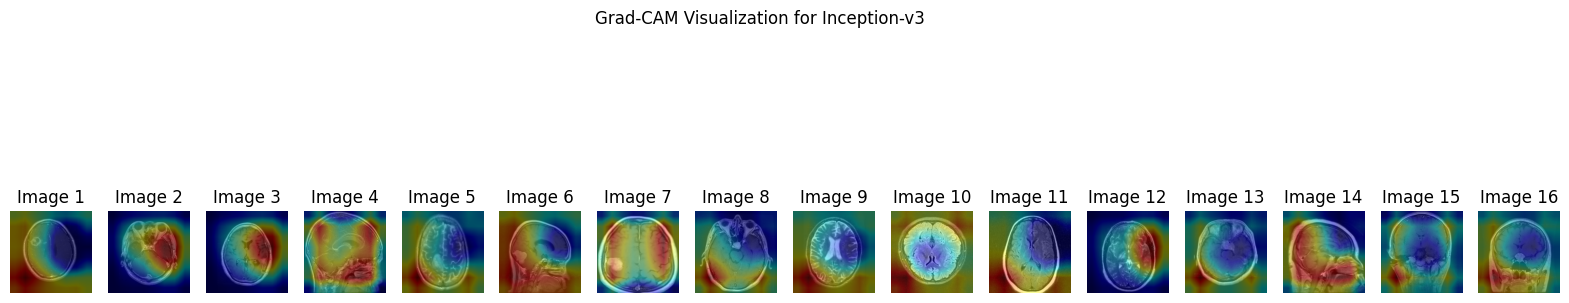

In [24]:
import torch
import torch.nn.functional as F
from torchvision import models, transforms
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Inception-v3 model
model = models.inception_v3(pretrained=False)
num_features = model.fc.in_features
model.fc = torch.nn.Linear(num_features, 4)
model.load_state_dict(torch.load("brain_tumor_inception.pth", map_location=device))
model.eval().to(device)

# Grad-CAM Implementation for Inception-v3
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradient = None
        self.activation = None
        self.target_layer.register_forward_hook(self.forward_hook)

    def forward_hook(self, module, input, output):
        self.activation = output
        output.register_hook(self.backward_hook)

    def backward_hook(self, grad):
        self.gradient = grad

    def generate_heatmap(self, image, class_idx):
        self.model.zero_grad()
        output = self.model(image)
        if isinstance(output, tuple):  # Inception-v3 outputs (logits, aux_logits)
            output = output[0]
        score = output[:, class_idx]
        score.backward()

        weights = self.gradient.mean(dim=[2, 3], keepdim=True)
        cam = (weights * self.activation).sum(dim=1, keepdim=True)
        cam = F.relu(cam).squeeze().detach().cpu().numpy()
        cam = (cam - cam.min()) / (cam.max() - cam.min())
        return cam

def apply_heatmap(image_path, heatmap):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (299, 299))  # Inception uses 299x299 input
    heatmap = cv2.resize(heatmap, (299, 299))

    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    return cv2.addWeighted(image, 0.6, heatmap, 0.4, 0)

transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# List of image paths
image_paths = [
    "/root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1/Testing/glioma/Te-gl_0027.jpg",
    "/root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1/Testing/glioma/Te-gl_0099.jpg",
    "/root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1/Testing/glioma/Te-gl_0019.jpg",
    "/root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1/Testing/glioma/Te-gl_0226.jpg",

    "/root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1/Testing/meningioma/Te-me_0037.jpg",
    "/root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1/Testing/meningioma/Te-me_0281.jpg",
    "/root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1/Testing/meningioma/Te-me_0023.jpg",
    "/root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1/Testing/meningioma/Te-me_0193.jpg",

    "/root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1/Testing/notumor/Te-no_0114.jpg",
    "/root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1/Testing/notumor/Te-no_0323.jpg",
    "/root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1/Testing/notumor/Te-no_0156.jpg",
    "/root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1/Testing/notumor/Te-no_0210.jpg",

    "/root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1/Testing/pituitary/Te-pi_0187.jpg",
    "/root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1/Testing/pituitary/Te-pi_0246.jpg",
    "/root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1/Testing/pituitary/Te-pi_0259.jpg",
    "/root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1/Testing/pituitary/Te-pi_0086.jpg",
]


target_layer = model.Mixed_7c  # Last convolutional layer in Inception-v3
grad_cam = GradCAM(model, target_layer)

fig, axes = plt.subplots(1, len(image_paths), figsize=(20, 5))  # Create subplots

for i, image_path in enumerate(image_paths):
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0).to(device)

    class_idx = torch.argmax(model(image_tensor)[0]).item()  # Inception outputs logits as tuple
    heatmap = grad_cam.generate_heatmap(image_tensor, class_idx)
    result_img = apply_heatmap(image_path, heatmap)

    result_img_rgb = cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB)
    axes[i].imshow(result_img_rgb)
    axes[i].axis("off")
    axes[i].set_title(f"Image {i+1}")

plt.suptitle("Grad-CAM Visualization for Inception-v3")
plt.show()


In [25]:
from google.colab import files

files.download("brain_tumor_inception.pth")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>